In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

import corner


In [2]:
import xoflares #  the flares code

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.2.4.dev69+gc063778
1.0.4
3.7


In [7]:
#  let's create some take data
#  we simulate 20 flares. In reality the flares enengies are distributed like a power law,
#  but that's not easy to draw from here, so we'll make the amplitudes follow a power law.
#  Inside the model, we learn the shape of the power law, in the real stars example, we want to
#  learn that function of ED, not amplitude.
t = np.arange(0,25,2/1440)
npeaks = 20
tpeaks = np.random.choice(t, size=npeaks)
fwhms = np.random.uniform(size=npeaks, low=6/1440, high=60/1440)

a = 2
mconst = 2
ampls = (a * mconst**a) / (np.random.uniform(size=npeaks) ** -(1+a))
# ampls = np.random.pareto(a=1.8, size=20)

In [8]:
data_len = t.shape[0]

In [9]:
y = xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls)
y_orig = np.copy(y)
yerr = 0.1 * np.ones_like(y)
y +=  np.random.normal(scale=yerr, size=np.shape(t)[0])
x = t

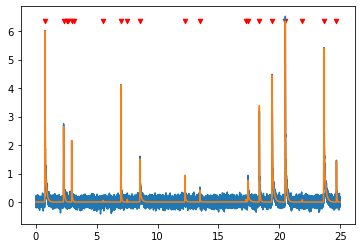

In [11]:
plt.plot(t, y)
plt.plot(t, xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls))
plt.scatter(tpeaks, np.zeros_like(tpeaks) + np.max(ampls), color='r', s=20, marker='v')

In [12]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:
        
        xval = pm.Data('xval', x[mask])
        data = pm.Data('data', y[mask])
        data_err = pm.Data('data_err', yerr[mask])

        tpeaks_d = tpeaks
        fwhms_d = fwhms
        ampls_d = ampls

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=2.0)

        BoundedNormal = pm.Bound(pm.Normal, lower=0)
        tpeak = BoundedNormal("tpeak", mu=tpeaks_d, sd=0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=tt.log(fwhms_d), sd=0.1, testval=tt.log(fwhms_d),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=tt.log(ampls_d), sd=0.1, testval=tt.log(ampls_d),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(xval, tpeak, fwhm, ampl, oversample=9, texp=None)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        pm.Normal('obs', mu=light_curve + mean, sd=data_err, observed=data,
                 total_size=data_len)

#        prior on the flare energies, loglike of pareto dist
        logalpha = pm.Normal('logalpha', mu=np.log(a), sd=1)
        alpha = pm.Deterministic('alpha', tt.exp(logalpha))
        m = BoundedNormal('m', mu=mconst, sd=0.1)
        pm.Potential('ampls_hyper',( npeaks*np.log(alpha)) +
                     (npeaks*alpha*np.log(m)) -
                     (alpha+1)*tt.sum(ampl))

        ED_days = xoflares.multiflareintegral(fwhm, ampl)
        pm.Deterministic("ED_days", ED_days)
    
        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])

        map_soln = xo.optimize(start=map_soln, vars=[mean])

#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [mean]
5it [00:02,  2.48it/s, logp=1.602172e+04]  
message: Optimization terminated successfully.
logp: 16021.023155038069 -> 16021.720130530515
optimizing logp for variables: [mean, logFwhm]
58it [00:01, 39.84it/s, logp=1.602510e+04]
message: Optimization terminated successfully.
logp: 16021.720130530515 -> 16025.095037264991
optimizing logp for variables: [mean, logAmpl]
78it [00:01, 43.10it/s, logp=1.602699e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16025.095037264991 -> 16026.989766454153
optimizing logp for variables: [logAmpl, logFwhm]
53it [00:01, 33.25it/s, logp=1.602801e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16026.989766454153 -> 16028.012342588641
optimizing logp for variables: [tpeak]
137it [00:02, 52.90it/s, logp=1.603018e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16028.012342588641 -> 16030.175313701438
optimizing logp for 

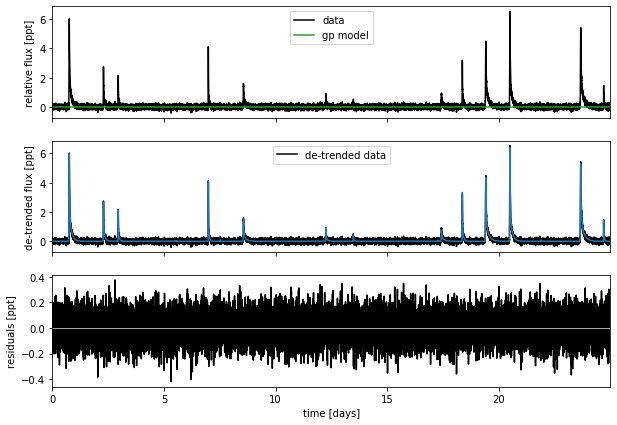

In [13]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = np.ones_like(x[mask]) * soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

optimizing logp for variables: [mean]
3it [00:00,  4.13it/s, logp=1.603018e+04] 
message: Optimization terminated successfully.
logp: 16030.175820547796 -> 16030.175820547796
optimizing logp for variables: [mean, logFwhm]
74it [00:01, 45.42it/s, logp=1.603041e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16030.175820547796 -> 16030.635047133455
optimizing logp for variables: [mean, logAmpl]
49it [00:01, 36.20it/s, logp=1.603099e+04]
message: Optimization terminated successfully.
logp: 16030.635047133455 -> 16030.993488831624
optimizing logp for variables: [logAmpl, logFwhm]
73it [00:01, 44.71it/s, logp=1.603077e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16030.993488831624 -> 16030.993488831624
optimizing logp for variables: [tpeak]
88it [00:02, 36.80it/s, logp=1.603081e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 16030.993488831624 -> 16031.040233799638
optimizing logp for va

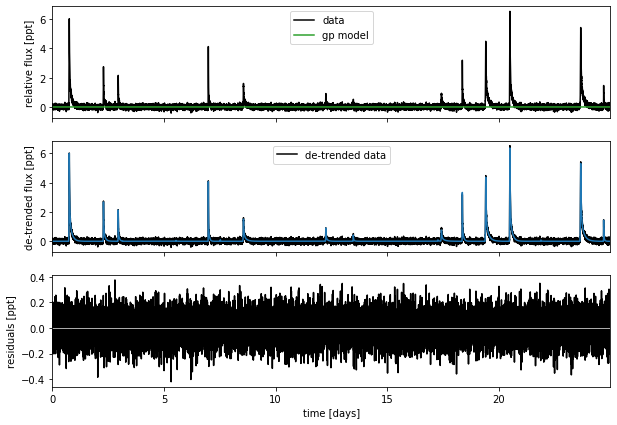

In [14]:
model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [15]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

optimizing logp for variables: [m, logalpha, logAmpl, logFwhm, tpeak, mean]
73it [00:02, 35.36it/s, logp=1.145111e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 16031.040233823496 -> 16031.040233823496


In [ ]:
with model:

    trace = pm.sample(tune=3000, draws=2000, start=map_soln2, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9, doubling=True, adaptation_window=101),
                     )